In [1]:
import lowmapper as lm

import os
import math
import time
from pathlib import Path
import shutil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import yaml

start_time = time.time()
print('[INFO] Loading config...')
config_path = 'cfg/default.yaml'
config = lm.parse_yaml(config_path)
lm.display_config(config)
print(f'Time elapsed: {time.time() - start_time:.2f}s')

[INFO] Loading config...
config: sonar_path=examples/Sonar_2023-09-12_09.04.57.sl2, save_path=outputs, filename_as_project_name=True, project_name=Sonar, transducer_x_offset=0,0, transducer_y_offset=0,0, egn=True, egn_stretch=2, egn_stretch_factor_min=25, egn_stretch_factor_max=75, water_column_present=True, water_column_removed=False, sonogram_img_format=png, export_speed_corrected=False, speed_correction=0, remove_shadows=0, depth_detection_method=0, smooth_depth=True, adjust_depth=0, plot_bedpicks=0, pixel_res=1, export_georef_sidescan=gtiff, export_sidescan_substrates_map=True, sidescan_wcp=True, sidescan_wcr=True, colormap=hotdog, map_substrate=False, subtrate_plots=False, substrate_raster=False, substrate_polygon=False, classification_method=max, 
Time elapsed: 0.00s


In [2]:
start_time = time.time()
print('\n[INFO] Reading sonar data...')
sonar = lm.Sonar(config['sonar_path'], config, augment_coords=False) #todo one cofnig
print(f'Time elapsed: {time.time() - start_time:.2f}s')


[INFO] Reading sonar data...
Time elapsed: 0.25s


In [3]:
if config['filename_as_project_name']:
    project_name = Path(config['sonar_path']).stem
else:
    project_name = config['project_name']
project_folder = os.path.join(config['save_path'], project_name)
    
if not os.path.exists(project_folder):
    print(f"Project folder not found. Creating project folder ({project_name})...")
    os.makedirs(project_folder)
else:
    print(f"Project folder exists. Removing project folder...")
    shutil.rmtree(project_folder)
    print(f"Creating project folder ({project_name})...")
    os.makedirs(project_folder)
    
    sidescan = lm.SideScan(
    sonar.sidescan_df(),
    config
)

start_time = time.time()
print('\n[INFO] Creating csv(s)...')
sonar.csvs()
print(f'Time elapsed: {time.time() - start_time:.2f}s')


start_time = time.time()
print('\n[INFO] Creating sonograms...')
sonar.primary_image()
sonar.downscan_image()
sidescan.sonograms()
print(f'Time elapsed: {time.time() - start_time:.2f}s')

start_time = time.time()
print('\n[INFO] Creating georeferenced side scans...')
sidescan.georeferenced()
print(f'Time elapsed: {time.time() - start_time:.2f}s')

Project folder exists. Removing project folder...
Creating project folder (Sonar_2023-09-12_09.04.57)...

[INFO] Creating csv(s)...
Exporting csv(s)...
Time elapsed: 1.36s

[INFO] Creating sonograms...
Exporting `primary` channel sonogram...
Exporting `downscan` channel sonogram...
Creating water column present...
Applying EGN on sidescan_wcp...
Applying EGN percentile clip stretch on sidescan_wcp...
Exporting `sidescan` channel sonogram(s)...
Time elapsed: 1.53s

[INFO] Creating georeferenced side scans...
Exporting georeferenced sidescan(s)...
Time elapsed: 1.40s


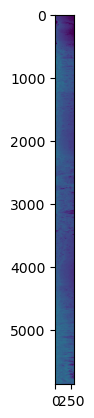

In [12]:
plt.imshow(sonar.bottom('downscan'))

In [ ]:
port = sidescan.port()
starboard = sidescan.starboard()

pixel = port.shape[1]
absolute_range = 60.015118
depths = np.stack(sonar.df.query(f"survey == 'sidescan'")["water_depth"])

port_pixel_depths = ((depths * pixel) / absolute_range).astype(int)
starboard_pixel_depths = ((depths * pixel) / absolute_range).astype(int)

port_wcr = np.copy(port)
starboard_wcr = np.copy(starboard)

for i, (port_pixel_depth, starboard_pixel_depth) in enumerate(zip(port_pixel_depths, starboard_pixel_depths)):
    port_wcr[i] = np.concatenate((np.zeros(port_pixel_depth).astype(int), port_wcr[i, :-port_pixel_depth]))

    starboard_wcr[i] = np.concatenate((starboard_wcr[i, starboard_pixel_depth:], np.zeros((starboard_pixel_depth)).astype(int)))
    
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes[0, 0].imshow(port, cmap='gray')
axes[0, 0].set_title('Original Port')

axes[0, 1].imshow(port_wcr, cmap='gray')
axes[0, 1].set_title('Port with Water Column Removed')

axes[1, 0].imshow(starboard, cmap='gray')
axes[1, 0].set_title('Original Starboard')

axes[1, 1].imshow(starboard_wcr, cmap='gray')
axes[1, 1].set_title('Starboard with Water Column Removed')


AttributeError: 'numpy.ndarray' object has no attribute 'port'

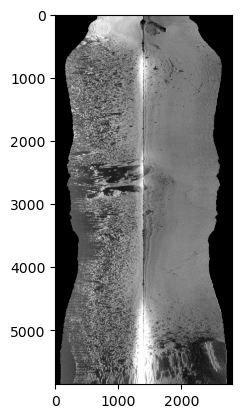

In [ ]:
combined = np.concatenate((port_wcr, starboard_wcr), axis=1)
plt.imshow(combined, cmap='gray')
plt.imsave('combined.png', combined, cmap='gray')

(5857, 1400)

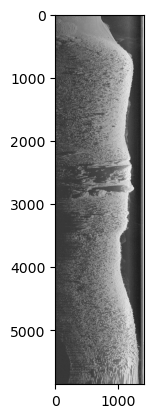

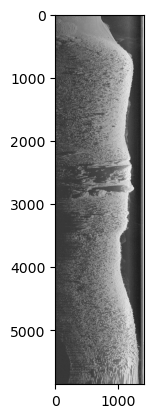

In [ ]:
s = sidescan._port()
plt.imshow(s, cmap='gray')
s.shape

Nn = s.shape[0]
Nm = s.shape[1]

h = np.stack(sonar.df.query(f"survey == 'sidescan'")["water_depth"])
h_range = np.sqrt(60.015118**2 - h**2).astype(int)

h_ranges = np.linspace(h_range, h, Nm, axis=1).astype(int)
h_ranges = ((h_ranges * 1400) / 60.015118).astype(int)

s2 = np.zeros((Nn, Nm))

for n in range(Nn):
    ping = np.zeros((Nm))
    for m in range(Nm):
        ping[m] = s[n][-h_ranges[n][m]]
    s2[n] = ping

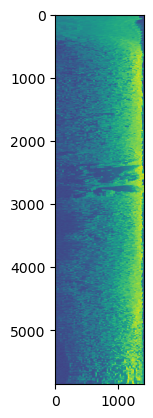

In [ ]:
plt.imshow(s2)

In [ ]:
h = np.stack(sonar.df.query(f"survey == 'sidescan'")["water_depth"])
#n = np.arange(0, Nn) # Nn-1 already
#m = np.arange(0, Nm)

In [ ]:
h_range = np.sqrt(60.015118**2 - h**2).astype(int)
# get distinct values from h_range
h_range.shape

(5857,)

In [ ]:
h_ranges = np.linspace(h_range, h, Nm, axis=1).astype(int)
h_ranges = ((h_ranges * 1400) / 60.015118).astype(int)
h_ranges[1]

array([1213, 1189, 1189, ...,  653,  653,  653])

In [ ]:

plt.imshow(s2)

NameError: name 's2' is not defined

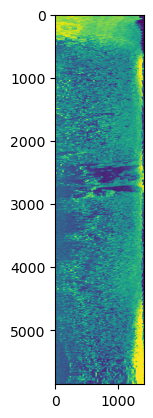

In [ ]:
s2 = np.zeros((Nn, Nm))

for n in range(Nn):
    ping = np.zeros((Nm))
    for m in range(Nm):
        ping[m] = s[n][-h_ranges[n][m]]
    s2[n] = ping

plt.imshow(s2)

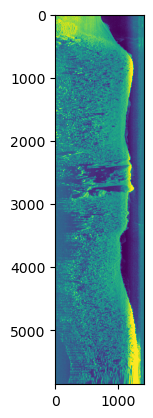

In [ ]:
plt.imshow(s)

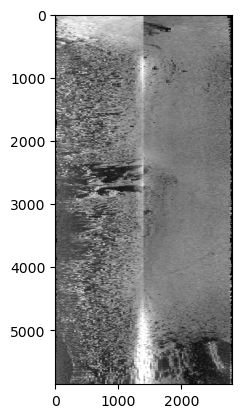

In [ ]:
combined = np.concatenate((port_slant, starboard_slant), axis=1)
plt.imshow(combined, cmap='gray')
plt.imsave('combined.png', combined, cmap='gray')

In [ ]:
sidescan.df

,id,survey,datetime,x,y,longitude,latitude,min_range,max_range,water_depth,gps_speed,gps_heading,gps_altitude,water_temperature,bottom_index,frames,x_augmented,y_augmented,longitude_augmented,latitude_augmented
4,0,sidescan,2023-09-12 01:50:00.967999935,13418426,1528066,120.945278,13.642268,-60.015118,60.015118,28.280653,0.818293,5.913069,49.930000,28.610001,659,"[72, 74, 65, 52, 35, 67, 65, 65, 64, 76, 76, 6...",1.341843e+07,1.528066e+06,120.945277,13.642271
9,1,sidescan,2023-09-12 01:50:00.979000092,13418426,1528066,120.945278,13.642268,-60.015118,60.015118,28.291668,0.818293,5.913069,49.930000,28.610001,659,"[74, 68, 68, 59, 54, 64, 50, 62, 62, 71, 65, 7...",1.341843e+07,1.528066e+06,120.945277,13.642271
14,2,sidescan,2023-09-12 01:50:01.232000113,13418426,1528066,120.945278,13.642268,-60.015118,60.015118,28.302183,0.827624,5.905777,49.919998,28.610001,660,"[73, 71, 71, 59, 68, 76, 65, 51, 54, 68, 72, 7...",1.341843e+07,1.528067e+06,120.945276,13.642273
19,3,sidescan,2023-09-12 01:50:01.250999927,13418426,1528066,120.945278,13.642268,-60.015118,60.015118,28.312199,0.827624,5.905777,49.919998,28.610001,660,"[79, 78, 80, 69, 59, 64, 63, 57, 50, 72, 62, 7...",1.341843e+07,1.528067e+06,120.945276,13.642273
24,4,sidescan,2023-09-12 01:50:01.493999958,13418426,1528066,120.945278,13.642268,-60.015118,60.015118,28.321592,0.839571,5.898584,49.910000,28.610001,660,"[83, 75, 48, 69, 69, 69, 68, 56, 46, 63, 71, 6...",1.341843e+07,1.528067e+06,120.945275,13.642276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29264,5852,sidescan,2023-09-12 01:59:53.460999966,13417762,1528582,120.939293,13.646788,-60.015118,60.015118,3.859924,0.115957,2.053352,51.389999,28.860001,90,"[31, 36, 38, 39, 37, 31, 38, 41, 31, 37, 36, 2...",1.341776e+07,1.528582e+06,120.939287,13.646789
29269,5853,sidescan,2023-09-12 01:59:53.566999912,13417762,1528582,120.939293,13.646788,-60.015118,60.015118,3.829523,0.114795,2.069404,51.339996,28.860001,89,"[48, 46, 38, 38, 29, 41, 44, 35, 33, 43, 43, 4...",1.341776e+07,1.528582e+06,120.939287,13.646789
29274,5854,sidescan,2023-09-12 01:59:53.667999983,13417762,1528582,120.939293,13.646788,-60.015118,60.015118,3.829523,0.113737,2.084029,51.339996,28.860001,89,"[39, 39, 32, 31, 31, 21, 29, 42, 21, 33, 44, 4...",1.341776e+07,1.528582e+06,120.939287,13.646789
29279,5855,sidescan,2023-09-12 01:59:53.773000002,13417762,1528582,120.939293,13.646788,-60.015118,60.015118,3.748778,0.112772,2.097355,51.339996,28.860001,87,"[42, 40, 41, 40, 44, 44, 43, 41, 22, 33, 39, 4...",1.341776e+07,1.528582e+06,120.939287,13.646789


In [ ]:
sidescan_df = sidescan.df

# copy the original dataframe
sidescan_df2 = sidescan_df.copy()

In [ ]:
times = sidescan_df2['cumulative_time_elapsed_seconds'].to_numpy()
speeds = sidescan_df2['gps_speed'].to_numpy()
ds = np.zeros((len(times)))

In [ ]:
times

array([0.00000000e+00, 1.10001570e-02, 2.64000178e-01, ...,
       5.92700000e+02, 5.92805000e+02, 5.92910000e+02])

In [ ]:
times1 = times[1:]
speeds1 = speeds[1:]
times = times[:-1]

In [ ]:
# Calculate instantaneous distance
d = (times1-times)*speeds1
ds[1:] = d
d

array([0.00900135, 0.2093889 , 0.0157247 , ..., 0.0114874 , 0.01184107,
       0.01174879])

In [ ]:
ds = np.cumsum(ds)

sidescan_df2['track_distance'] = ds

In [ ]:
sidescan_df2

,id,survey,datetime,x,y,longitude,latitude,min_range,max_range,water_depth,...,bottom_index,frames,x_augmented,y_augmented,longitude_augmented,latitude_augmented,time_elapsed,time_elapsed_seconds,cumulative_time_elapsed_seconds,track_distance
4,0,sidescan,2023-09-12 01:50:00.967999935,13418426,1528066,120.945278,13.642268,-60.015118,60.015118,28.280653,...,659,"[72, 74, 65, 52, 35, 67, 65, 65, 64, 76, 76, 6...",1.341843e+07,1.528066e+06,120.945277,13.642271,0 days 00:00:00,0.000,0.000,0.000000
9,1,sidescan,2023-09-12 01:50:00.979000092,13418426,1528066,120.945278,13.642268,-60.015118,60.015118,28.291668,...,659,"[74, 68, 68, 59, 54, 64, 50, 62, 62, 71, 65, 7...",1.341843e+07,1.528066e+06,120.945277,13.642271,0 days 00:00:00.011000157,0.011,0.011,0.009001
14,2,sidescan,2023-09-12 01:50:01.232000113,13418426,1528066,120.945278,13.642268,-60.015118,60.015118,28.302183,...,660,"[73, 71, 71, 59, 68, 76, 65, 51, 54, 68, 72, 7...",1.341843e+07,1.528067e+06,120.945276,13.642273,0 days 00:00:00.253000021,0.253,0.264,0.218390
19,3,sidescan,2023-09-12 01:50:01.250999927,13418426,1528066,120.945278,13.642268,-60.015118,60.015118,28.312199,...,660,"[79, 78, 80, 69, 59, 64, 63, 57, 50, 72, 62, 7...",1.341843e+07,1.528067e+06,120.945276,13.642273,0 days 00:00:00.018999814,0.019,0.283,0.234115
24,4,sidescan,2023-09-12 01:50:01.493999958,13418426,1528066,120.945278,13.642268,-60.015118,60.015118,28.321592,...,660,"[83, 75, 48, 69, 69, 69, 68, 56, 46, 63, 71, 6...",1.341843e+07,1.528067e+06,120.945275,13.642276,0 days 00:00:00.243000031,0.243,0.526,0.438131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29264,5852,sidescan,2023-09-12 01:59:53.460999966,13417762,1528582,120.939293,13.646788,-60.015118,60.015118,3.859924,...,90,"[31, 36, 38, 39, 37, 31, 38, 41, 31, 37, 36, 2...",1.341776e+07,1.528582e+06,120.939287,13.646789,0 days 00:00:00.079999924,0.080,592.493,867.621469
29269,5853,sidescan,2023-09-12 01:59:53.566999912,13417762,1528582,120.939293,13.646788,-60.015118,60.015118,3.829523,...,89,"[48, 46, 38, 38, 29, 41, 44, 35, 33, 43, 43, 4...",1.341776e+07,1.528582e+06,120.939287,13.646789,0 days 00:00:00.105999946,0.106,592.599,867.633637
29274,5854,sidescan,2023-09-12 01:59:53.667999983,13417762,1528582,120.939293,13.646788,-60.015118,60.015118,3.829523,...,89,"[39, 39, 32, 31, 31, 21, 29, 42, 21, 33, 44, 4...",1.341776e+07,1.528582e+06,120.939287,13.646789,0 days 00:00:00.101000071,0.101,592.700,867.645125
29279,5855,sidescan,2023-09-12 01:59:53.773000002,13417762,1528582,120.939293,13.646788,-60.015118,60.015118,3.748778,...,87,"[42, 40, 41, 40, 44, 44, 43, 41, 22, 33, 39, 4...",1.341776e+07,1.528582e+06,120.939287,13.646789,0 days 00:00:00.105000019,0.105,592.805,867.656966


In [ ]:
#from skimage.transform import resize

# Distance (in meters)
d = sidescan_df2['track_distance'].to_numpy()

In [ ]:
d =np.max(d) - np.min(d)

In [ ]:
np.round((d * 1400)/ 60.015118, 0).astype(int)

20241

In [ ]:
#d = round(d / self.pixM, 0).astype(int)

# sonDat = resize(sonDat,
#                 (sonDat.shape[0], d),
#                 mode='reflect',
#                 clip=True,
#                 preserve_range=True)

In [ ]:
# Assuming 'sidescan_df2' is your DataFrame containing the ping data

# Calculate the time elapsed between consecutive pings
sidescan_df2['time_elapsed'] = (
    sidescan_df2['datetime'] - sidescan_df2['datetime'].shift()
).fillna(pd.Timedelta(seconds=0))

# Convert the time elapsed to seconds
sidescan_df2['time_elapsed_seconds'] = sidescan_df2['time_elapsed'].dt.total_seconds()

# Cumulatively sum the time elapsed values to get the total time elapsed from the first ping to each subsequent ping
sidescan_df2['cumulative_time_elapsed_seconds'] = sidescan_df2['time_elapsed_seconds'].cumsum()

sidescan_df2

,id,survey,datetime,x,y,longitude,latitude,min_range,max_range,water_depth,...,water_temperature,bottom_index,frames,x_augmented,y_augmented,longitude_augmented,latitude_augmented,time_elapsed,time_elapsed_seconds,cumulative_time_elapsed_seconds
4,0,sidescan,2023-09-12 01:50:00.967999935,13418426,1528066,120.945278,13.642268,-60.015118,60.015118,28.280653,...,28.610001,659,"[72, 74, 65, 52, 35, 67, 65, 65, 64, 76, 76, 6...",1.341843e+07,1.528066e+06,120.945277,13.642271,0 days 00:00:00,0.000,0.000
9,1,sidescan,2023-09-12 01:50:00.979000092,13418426,1528066,120.945278,13.642268,-60.015118,60.015118,28.291668,...,28.610001,659,"[74, 68, 68, 59, 54, 64, 50, 62, 62, 71, 65, 7...",1.341843e+07,1.528066e+06,120.945277,13.642271,0 days 00:00:00.011000157,0.011,0.011
14,2,sidescan,2023-09-12 01:50:01.232000113,13418426,1528066,120.945278,13.642268,-60.015118,60.015118,28.302183,...,28.610001,660,"[73, 71, 71, 59, 68, 76, 65, 51, 54, 68, 72, 7...",1.341843e+07,1.528067e+06,120.945276,13.642273,0 days 00:00:00.253000021,0.253,0.264
19,3,sidescan,2023-09-12 01:50:01.250999927,13418426,1528066,120.945278,13.642268,-60.015118,60.015118,28.312199,...,28.610001,660,"[79, 78, 80, 69, 59, 64, 63, 57, 50, 72, 62, 7...",1.341843e+07,1.528067e+06,120.945276,13.642273,0 days 00:00:00.018999814,0.019,0.283
24,4,sidescan,2023-09-12 01:50:01.493999958,13418426,1528066,120.945278,13.642268,-60.015118,60.015118,28.321592,...,28.610001,660,"[83, 75, 48, 69, 69, 69, 68, 56, 46, 63, 71, 6...",1.341843e+07,1.528067e+06,120.945275,13.642276,0 days 00:00:00.243000031,0.243,0.526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29264,5852,sidescan,2023-09-12 01:59:53.460999966,13417762,1528582,120.939293,13.646788,-60.015118,60.015118,3.859924,...,28.860001,90,"[31, 36, 38, 39, 37, 31, 38, 41, 31, 37, 36, 2...",1.341776e+07,1.528582e+06,120.939287,13.646789,0 days 00:00:00.079999924,0.080,592.493
29269,5853,sidescan,2023-09-12 01:59:53.566999912,13417762,1528582,120.939293,13.646788,-60.015118,60.015118,3.829523,...,28.860001,89,"[48, 46, 38, 38, 29, 41, 44, 35, 33, 43, 43, 4...",1.341776e+07,1.528582e+06,120.939287,13.646789,0 days 00:00:00.105999946,0.106,592.599
29274,5854,sidescan,2023-09-12 01:59:53.667999983,13417762,1528582,120.939293,13.646788,-60.015118,60.015118,3.829523,...,28.860001,89,"[39, 39, 32, 31, 31, 21, 29, 42, 21, 33, 44, 4...",1.341776e+07,1.528582e+06,120.939287,13.646789,0 days 00:00:00.101000071,0.101,592.700
29279,5855,sidescan,2023-09-12 01:59:53.773000002,13417762,1528582,120.939293,13.646788,-60.015118,60.015118,3.748778,...,28.860001,87,"[42, 40, 41, 40, 44, 44, 43, 41, 22, 33, 39, 4...",1.341776e+07,1.528582e+06,120.939287,13.646789,0 days 00:00:00.105000019,0.105,592.805
